In [1]:
import openchord as ocd
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
# go one up
os.chdir("..")

In [2]:
vos_links = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_links.csv')
vos_links.head()

,VOS_Source_ID,VOS_Target_ID,Strength
0,2,3,2.4269
1,2,4,0.0215
2,2,7,0.0081
3,2,8,0.3474
4,2,10,0.1061


In [3]:
vos_links.max()

VOS_Source_ID    3453.0000
VOS_Target_ID    3454.0000
Strength           74.7694
dtype: float64

In [4]:
vos_meta = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_meta.csv')
vos_meta.head()

,VOS_ID,Authors,Title,Year,Citations,Source,Cluster,Links,Total link strength,Norm. citations
0,2,['Nick Bostrom'],Existential Risk Prevention As Global Priority,2013,387.0,Global policy,3,303.0,33.0,11.8575
1,3,['Nick Bostrom'],Existential Risks: Analyzing Human Extinction ...,2002,176.0,[no source],3,61.0,24.0,3.7625
2,4,"['Shahar Avin', ' Bonnie C. Wintle', ' Julius ...",Classifying Global Catastrophic Risks,2018,68.0,Futures,3,226.0,13.0,4.6723
3,7,"['Simon Beard', ' Lauren Holt', ' Asaf Tzachor...",Assessing Climate Change’S Contribution To Glo...,2021,41.0,Futures,3,287.0,56.0,5.3588
4,8,"['Alexey Turchin', ' David Denkenberger']",Classification Of Global Catastrophic Risks Co...,2018,53.0,Ai & society,1,208.0,22.0,3.6416


In [5]:
# Remove the discarded clusters
other_topic_clusters = [6, 7, 8, 12, 14, 15, 18, 19, 22, 23, 24, 25]
vos_meta = vos_meta[~vos_meta['Cluster'].isin(other_topic_clusters)]

In [6]:
# Merge via the 'VOS_ID' column
vos_source = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Source_ID', how="right")
vos_source = vos_source[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_source.columns = ['Source', 'Target', 'Strength', 'Source Cluster']
vos_source.head()

,Source,Target,Strength,Source Cluster
0,2.0,3.0,2.4269,3
1,2.0,4.0,0.0215,3
2,2.0,7.0,0.0081,3
3,2.0,8.0,0.3474,3
4,2.0,10.0,0.1061,3


In [7]:
# Merge again to get the target cluster
vos_target = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Target_ID', how="right")
vos_target = vos_target[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_target.columns = ['Source', 'Target', 'Strength', 'Target Cluster']
vos_target.head()


,Source,Target,Strength,Target Cluster
0,NaN,NaN,NaN,3
1,2.0,3.0,2.4269,3
2,2.0,4.0,0.0215,3
3,2.0,7.0,0.0081,3
4,4.0,7.0,0.0906,3


In [8]:
#assert vos_target.shape[0] == vos_source.shape[0]
# Merge the two dataframes
vos = pd.merge(vos_source, vos_target, on=['Source', 'Target', 'Strength'])
vos.head()

,Source,Target,Strength,Source Cluster,Target Cluster
0,2.0,3.0,2.4269,3,3
1,2.0,4.0,0.0215,3,3
2,2.0,7.0,0.0081,3,3
3,2.0,8.0,0.3474,3,1
4,2.0,10.0,0.1061,3,3


In [9]:
# Analyse how much strength is from one cluster to another
cluster_strength = vos[["Strength", "Source Cluster", "Target Cluster"]].groupby(['Source Cluster', 'Target Cluster']).sum()
cluster_strength

Strength
Source Cluster Target Cluster           
1              1               1352.7242
               2                 57.7200
               3                134.8480
               4                 50.5589
               5                 28.8092
...                                  ...
21             13                 1.2365
               16                 0.3112
               17                 1.0968
               20                 0.2500
               21               122.5547

[167 rows x 1 columns]

In [10]:
# Create a graph from the cluster strength
G = nx.Graph()
for index, row in cluster_strength.iterrows():
    # Skip self loops
    if index[0] == index[1]:
        continue
    G.add_edge(index[0], index[1], weight=row['Strength'])

In [11]:
adjacency_matrix = nx.to_pandas_adjacency(G)
adjacency_matrix

,1,2,3,4,5,9,10,11,13,16,17,20,21
1,0.0000,47.9140,225.6981,59.6569,20.3759,39.6857,21.2030,38.3657,2.6527,10.9411,18.2645,3.3886,11.0106
2,47.9140,0.0000,214.2795,55.6900,33.5320,4.6886,9.2120,46.8709,15.6935,13.2297,6.5166,1.8657,21.9416
3,225.6981,214.2795,0.0000,32.6749,16.8597,23.1290,11.3069,69.4778,0.8352,9.7552,1.7353,4.0539,4.9621
4,59.6569,55.6900,32.6749,0.0000,28.3487,4.8388,2.5710,23.2903,4.8437,13.0312,2.7666,1.0243,8.7676
5,20.3759,33.5320,16.8597,28.3487,0.0000,3.8779,8.6134,12.4348,0.4702,5.5538,2.7500,1.0162,2.7452
9,39.6857,4.6886,23.1290,4.8388,3.8779,0.0000,1.9055,2.6733,1.0493,0.8174,1.3155,0.0324,1.5259
10,21.2030,9.2120,11.3069,2.5710,8.6134,1.9055,0.0000,2.5912,0.0164,2.5482,0.5000,0.1748,0.6157
11,38.3657,46.8709,69.4778,23.2903,12.4348,2.6733,2.5912,0.0000,0.0370,3.7994,0.0873,0.8080,3.9628
13,2.6527,15.6935,0.8352,4.8437,0.4702,1.0493,0.0164,0.0370,0.0000,4.3160,0.3416,0.6747,1.2365
16,10.9411,13.2297,9.7552,13.0312,5.5538,0.8174,2.5482,3.7994,4.3160,0.0000,0.2500,0.0081,0.3112


In [12]:
# Get an adjacency matrix
adjacency_matrix.columns = ["AI Ethics", "Governance of \nRisk and Climate", "Existential\nRisks", "Risk Policy", "Biosecurity\nGovernance", "Existential Risk\nEthics", "Risk from AI", "Global\nResilience", "Global Policy\nand Coordination", "Forecasting Global\nRisks", "Bioengineering", "Nuclear war\nand deterence", "Extreme Climate\nChange Mitigation"]
adjacency_matrix.index = ["AI Ethics", "Governance of \nRisk and Climate", "Existential\nRisks", "Risk Policy", "Biosecurity\nGovernance", "Existential Risk\nEthics", "Risk from AI", "Global\nResilience", "Global Policy\nand Coordination", "Forecasting Global\nRisks", "Bioengineering", "Nuclear war\nand deterence", "Extreme Climate\nChange Mitigation"]
adjacency_matrix

,AI Ethics,Governance of \nRisk and Climate,Existential\nRisks,Risk Policy,Biosecurity\nGovernance,Existential Risk\nEthics,Risk from AI,Global\nResilience,Global Policy\nand Coordination,Forecasting Global\nRisks,Bioengineering,Nuclear war\nand deterence,Extreme Climate\nChange Mitigation
AI Ethics,0.0000,47.9140,225.6981,59.6569,20.3759,39.6857,21.2030,38.3657,2.6527,10.9411,18.2645,3.3886,11.0106
Governance of \nRisk and Climate,47.9140,0.0000,214.2795,55.6900,33.5320,4.6886,9.2120,46.8709,15.6935,13.2297,6.5166,1.8657,21.9416
Existential\nRisks,225.6981,214.2795,0.0000,32.6749,16.8597,23.1290,11.3069,69.4778,0.8352,9.7552,1.7353,4.0539,4.9621
Risk Policy,59.6569,55.6900,32.6749,0.0000,28.3487,4.8388,2.5710,23.2903,4.8437,13.0312,2.7666,1.0243,8.7676
Biosecurity\nGovernance,20.3759,33.5320,16.8597,28.3487,0.0000,3.8779,8.6134,12.4348,0.4702,5.5538,2.7500,1.0162,2.7452
Existential Risk\nEthics,39.6857,4.6886,23.1290,4.8388,3.8779,0.0000,1.9055,2.6733,1.0493,0.8174,1.3155,0.0324,1.5259
Risk from AI,21.2030,9.2120,11.3069,2.5710,8.6134,1.9055,0.0000,2.5912,0.0164,2.5482,0.5000,0.1748,0.6157
Global\nResilience,38.3657,46.8709,69.4778,23.2903,12.4348,2.6733,2.5912,0.0000,0.0370,3.7994,0.0873,0.8080,3.9628
Global Policy\nand Coordination,2.6527,15.6935,0.8352,4.8437,0.4702,1.0493,0.0164,0.0370,0.0000,4.3160,0.3416,0.6747,1.2365
Forecasting Global\nRisks,10.9411,13.2297,9.7552,13.0312,5.5538,0.8174,2.5482,3.7994,4.3160,0.0000,0.2500,0.0081,0.3112


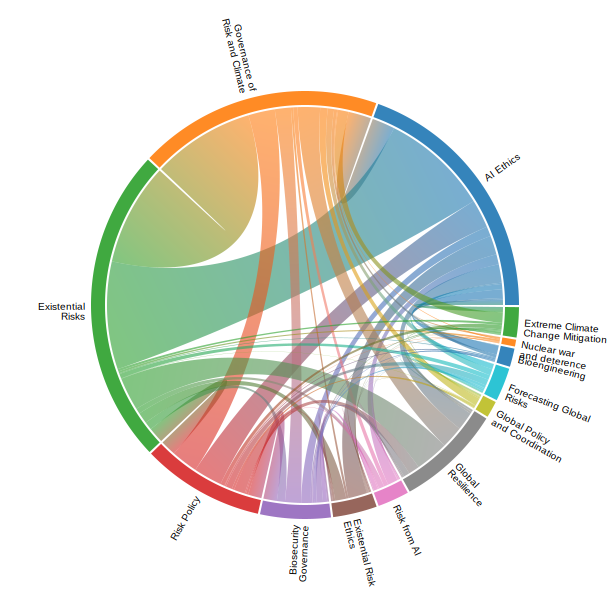

In [13]:
chord = ocd.Chord(adjacency_matrix, [str(i) for i in adjacency_matrix.columns])
# Get the colors from tab10
chord.colormap = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
chord.padding = 105
chord.show()